# Codereferenz

Der Code stammt von "Dive into Deep Learning":

https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html

# Benötigte Bibliotheken

In [4]:
!pip show d2l

Name: d2l
Version: 1.0.3
Summary: Dive into Deep Learning
Home-page: https://d2l.ai
Author: D2L Developers
Author-email: d2l.devs@gmail.com
License: MIT-0
Location: /home/juebrauer/miniconda3/envs/env_ws23/lib/python3.11/site-packages
Requires: jupyter, matplotlib, matplotlib-inline, numpy, pandas, requests, scipy
Required-by: 


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

# Aufteilung eines Bildes in Patches

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)


In [8]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
d2l.check_shape(patch_emb(X),
                (batch_size, (img_size//patch_size)**2, num_hiddens))

In [9]:
X.shape

torch.Size([4, 3, 96, 96])

In [11]:
patch_emb(X).shape

torch.Size([4, 36, 512])

In [12]:
96/16

6.0

# Der MLP-Block

In [14]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

# Der Encoder-Block

In [19]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [18]:
print( *([1,2,3]*3) )

1 2 3 1 2 3 1 2 3


In [20]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X), X.shape)

In [22]:
encoder_blk(X).shape

torch.Size([2, 100, 24])

# Das komplette Modell

In [23]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

# Vision Transformer Training

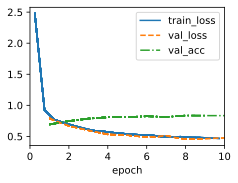

In [26]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 1
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

In [27]:
model

ViT(
  (patch_embedding): PatchEmbedding(
    (conv): Conv2d(1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (blks): Sequential(
    (0): ViTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=False)
        (W_k): Linear(in_features=512, out_features=512, bias=False)
        (W_v): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=512, out_features=512, bias=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): ViTMLP(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (gelu): GELU(approximate='none')
        (dropout1): Dropout(p=0.1, inplace=False)
        (dense2): Linear(in_features=2048, out_features=512,